In [3]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


In [8]:

# change this to your path
# pickle_path = "./../results/R0/R5.5_seed123_20251001-221335_results.pkl"
pickle_path = "./../test_rr_output_pop_local_sig/trained_model/r0.1_1_seed123_20251209-021428_results.pkl"

with open(pickle_path, "rb") as f:
    R = pickle.load(f)

In [9]:
r_true        = np.asarray(R.get("r_true"))
r_pred_mean   = np.asarray(R.get("r_pred_mean", R.get("r_pred")))  # fallback
r_pred_median = np.asarray(R.get("r_pred_median")) if "r_pred_median" in R else None
r_std         = np.asarray(R.get("r_std"))
r_ci_lo       = np.asarray(R.get("r_ci_lo")) if "r_ci_lo" in R else None
r_ci_hi       = np.asarray(R.get("r_ci_hi")) if "r_ci_hi" in R else None

print({k: v.shape if isinstance(v, np.ndarray) else type(v) 
       for k, v in dict(r_true=r_true, r_pred_mean=r_pred_mean, r_std=r_std).items()})

{'r_true': (1260,), 'r_pred_mean': (1260,), 'r_std': (1260,)}


In [6]:
1260/21

60.0

In [11]:
y_unseen_true = [] 
y_unseen_pred = [] 
y_unseen_lo = [] 
y_unseen_hi = []
for r in [0.08,0.4,4.0]:
    df_unseen = pd.read_csv('../results/R0/R5.5_batch_summary_r-{}.csv'.format(r))
    y_unseen_true.extend([r]*len(df_unseen))
    y_unseen_pred.extend(df_unseen['r_median'].to_list())
    y_unseen_lo.extend(df_unseen['ci_low'].to_list())
    y_unseen_hi.extend(df_unseen['ci_high'].to_list())

In [12]:
Y_test = (r_true, r_pred_median, r_pred_median-r_ci_lo, r_ci_hi-r_pred_median)
Y_unseen = (np.array(y_unseen_true), np.array(y_unseen_pred), np.array(y_unseen_pred)-np.array(y_unseen_lo), np.array(y_unseen_hi)-np.array(y_unseen_pred))

In [13]:
def plot_test_results(Y_test,Y_unseen,   save_dir,R0,y_max=30):
    y_true, y_pred, y_lo,y_hi = Y_test
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    print(y_true.shape, y_pred.shape)
    y_lo = np.asarray(y_lo).ravel()
    y_hi = np.asarray(y_hi).ravel()
    yerr = np.vstack([y_lo, y_hi])

    # add unseen data point
    y_true_u, y_pred_u, y_lo_u, y_hi_u = Y_unseen
    yerr_u = np.vstack([y_lo_u, y_hi_u])



    fig, ax = plt.subplots(figsize=(1.9,1.9),dpi=450)
    rs = np.linspace(0.01, y_max, 100)

    eb = ax.errorbar(
        y_true, y_pred, yerr=yerr,
        fmt='s', ms=2.5,
        mfc='#87ceeb', mec='none', mew=0.5,
        ecolor='#87ceeb', elinewidth=0.9, capsize=0, 
        alpha=0.5, label='Predicted ± 95%CI'
    )


    # eb_u = ax.errorbar(
    #     y_true_u, y_pred_u, yerr=yerr_u,
    #     fmt='s', ms=2.5,
    #     mfc='#9e80bf', mec='none', mew=0.5,
    #     ecolor='#9e80bf', elinewidth=0.7, capsize=0, 
    #     alpha=0.5, label='Predicted ± 95%CI'
    # )

    ax.plot(rs, rs, color='#ff5100', lw=1, ls='--',alpha=1, label='True $r$')
    # ax.plot(y_true, y_pred, lw=0.6, alpha=0.3, color='skyblue')

    # axes + limits
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlim(0.012, y_max); ax.set_ylim(0.012, y_max)
    ax.set_xlabel('$r$', size=6.5); ax.set_ylabel('$r$', size=6.5)
    ax.tick_params(axis='both', labelsize=6.5)

    # legend: show R0 in the True label, use eb container for errorbar glyph
    true_handle = Line2D([], [], color='orangered', lw=1)

    true_label = f'True $r$\n$R_0={R0:g}$'   # ← no leading r, \n makes a new line
    pred_label = 'Predicted ± 95%CI'

    leg1 = ax.legend([true_handle], [true_label],
                    loc='upper left', frameon=False, fontsize=6.5,
                    handlelength=1.5, handletextpad=0.8, borderaxespad=0.3)
    ax.add_artist(leg1)   # <-- keep the first legend

    # Legend 2 (predicted with CI)
    ax.legend([eb], [pred_label],
            loc='lower right', frameon=False, fontsize=6.5,
            handlelength=2, handletextpad=0.8, borderaxespad=0.3)

    # plt.tight_layout()
    # plt.savefig(save_dir+'test_R0-{}.png'.format(R0), dpi=450,bbox_inches="tight", pad_inches=0.02)

(1260,) (1260,)


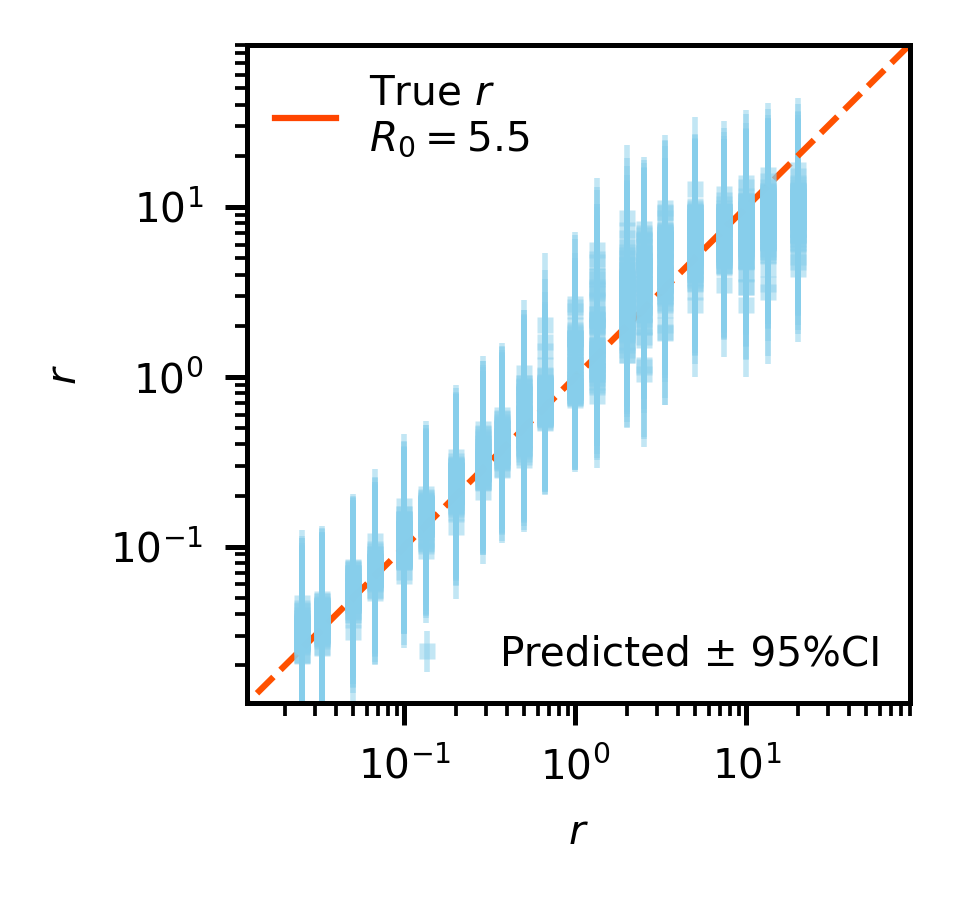

In [14]:
plot_test_results(Y_test,Y_unseen,save_dir='./../results/R0/',R0=5.5,y_max=90)

In [22]:
y_true = r_true
y_med = r_pred_median
y_lo = r_ci_lo
y_hi = r_ci_hi
inside = (y_true >= y_lo) & (y_true <= y_hi)
my_cov = np.sum(inside)/len(inside)
mask = y_true <= 5
if mask.any():
    cov_le5 = inside[mask].mean()

In [23]:
def coverage(y_true, y_lo, y_hi):
    inside = (y_true >= y_lo) & (y_true <= y_hi)
    my_cov = np.sum(inside)/len(inside)
    mask = y_true <= 5
    if mask.any():
        cov_le5 = inside[mask].mean()
    return my_cov, inside.mean(), inside, cov_le5

my, cov, inside, cov_le5 = coverage(r_true, r_ci_lo, r_ci_hi)

print(f"Overall 95% CI coverage = {cov*100:.1f}%  (ideal ≈ 95%)",my , cov_le5)

Overall 95% CI coverage = 98.9%  (ideal ≈ 95%) 0.9888888888888889 0.9937629937629938


In [ ]:


# coverage by true-r bins (on log scale)
def binned_coverage(y_true, y_lo, y_hi, nbins=8):
    bins = np.logspace(np.log10(y_true.min()), np.log10(y_true.max()), nbins+1)
    mids, covs, counts = [], [], []
    for a,b in zip(bins[:-1], bins[1:]):
        sel = (y_true>=a)&(y_true<b)
        if sel.any():
            c = ((y_true[sel]>=y_lo[sel]) & (y_true[sel]<=y_hi[sel])).mean()
            covs.append(c); counts.append(sel.sum()); mids.append(np.sqrt(a*b))
    return np.array(mids), np.array(covs), np.array(counts)

mids, covs, counts = binned_coverage(r_true, r_ci_lo, r_ci_hi, nbins=8)

Overall 95% CI coverage = 89.6%  (ideal ≈ 95%)


In [31]:
def bin_stats(x_true, x_pred, lo, hi, nbins=12):
    bins = np.logspace(np.log10(x_true.min()), np.log10(x_true.max()), nbins+1)
    xc, p_med, p_lo, p_hi = [], [], [], []
    for a,b in zip(bins[:-1], bins[1:]):
        sel = (x_true>=a)&(x_true<b)
        if sel.any():
            xc.append(np.sqrt(a*b))
            p_med.append(np.median(x_pred[sel]))
            p_lo.append(np.median(lo[sel]))
            p_hi.append(np.median(hi[sel]))
    return np.array(xc), np.array(p_med), np.array(p_lo), np.array(p_hi)

bx, bmed, blo, bhi = bin_stats(r_true, r_pred_median, r_ci_lo, r_ci_hi, nbins=10)

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_20958/3061725385.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


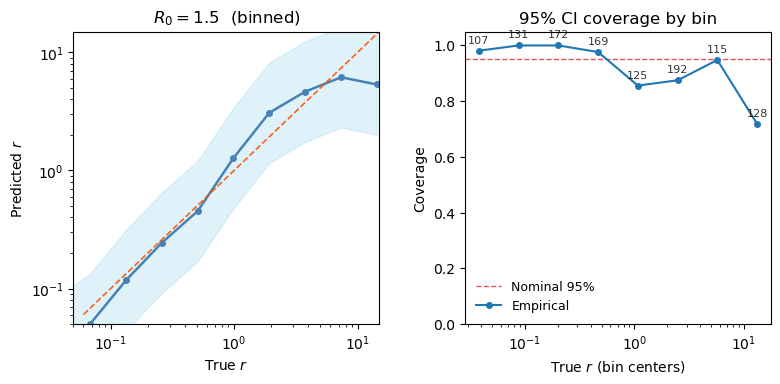

In [32]:
y_true = r_true
y_med = r_pred_median
y_lo = r_ci_lo
y_hi = r_ci_hi

lo_r, hi_r = 0.05, 15.0                         # zoom window
mask = (y_true >= lo_r) & (y_true <= hi_r)
xt, xm, xlo, xhi = y_true[mask], y_med[mask], y_lo[mask], y_hi[mask]

# optional: sort for pretty fill_between (not required here)
idx = np.argsort(xt)
xt, xm, xlo, xhi = xt[idx], xm[idx], xlo[idx], xhi[idx]

fig, axes = plt.subplots(1, 2, figsize=(9, 3.8), gridspec_kw={'wspace':0.28})

# ---- (A) Scatter with very light intervals per point (or drop them) ----
# ax = axes[0]
# ax.scatter(xt, xm, s=9, c='#1f77b4', alpha=0.7, linewidths=0)
# # tiny vertical whiskers (thin & faint), comment out if still busy
# for x, lo, hi in zip(xt, xlo, xhi):
#     ax.vlines(x, lo, hi, color='#1f77b4', alpha=0.12, lw=0.6)

# # 1:1 line
rng = [max(xt.min(), lo_r)*0.9, min(xt.max(), hi_r)*1.1]
ax.plot(rng, rng, '--', color='#ff5100', lw=1.2, alpha=0.9)

# ax.set_xscale('log'); ax.set_yscale('log')
# ax.set_xlim(lo_r, hi_r); ax.set_ylim(lo_r, hi_r)
# ax.set_xlabel(r'True $r$'); ax.set_ylabel(r'Predicted $r$')
# ax.set_title(rf'$R_0 = 1.5$  (zoom {lo_r}–{hi_r})')
axes[0].clear()
axes[0].fill_between(bx, blo, bhi, color='skyblue', alpha=0.25)
axes[0].plot(bx, bmed, 'o-', color='steelblue', lw=1.8, ms=4)
axes[0].plot(rng, rng, '--', color='#ff5100', lw=1.2, alpha=0.9)
axes[0].set_xscale('log'); axes[0].set_yscale('log')
axes[0].set_xlim(lo_r, hi_r); axes[0].set_ylim(lo_r, hi_r)
axes[0].set_xlabel(r'True $r$'); axes[0].set_ylabel(r'Predicted $r$')
axes[0].set_title(rf'$R_0 = 1.5$  (binned)')

# ---- (B) Coverage by true-r bin (with counts) ----
ax = axes[1]
ax.axhline(0.95, ls='--', lw=1, color='tab:red', alpha=0.8, label='Nominal 95%')
ax.plot(mids, covs, 'o-', color='#1f77b4', lw=1.5, ms=4, label='Empirical')
for x,cnt,cv in zip(mids, counts, covs):
    ax.text(x, cv+0.02, str(cnt), ha='center', va='bottom', fontsize=8, alpha=0.8)

ax.set_xscale('log'); ax.set_ylim(0, 1.05)
ax.set_xlabel(r'True $r$ (bin centers)'); ax.set_ylabel('Coverage')
ax.set_title('95% CI coverage by bin')
ax.legend(frameon=False, fontsize=9)
plt.tight_layout()

Text(0.5, 1.0, '$R_0 = 1.5$  (binned)')